<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-Walk" data-toc-modified-id="Random-Walk-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random Walk</a></span><ul class="toc-item"><li><span><a href="#Stationarity" data-toc-modified-id="Stationarity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Stationarity</a></span><ul class="toc-item"><li><span><a href="#Autocorrelation" data-toc-modified-id="Autocorrelation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Autocorrelation</a></span></li><li><span><a href="#Statistical-Tests" data-toc-modified-id="Statistical-Tests-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Statistical Tests</a></span></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prediction</a></span></li></ul></li><li><span><a href="#TakeAways" data-toc-modified-id="TakeAways-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TakeAways</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib

Ethen 2019-09-10 22:06:11 

CPython 3.6.4
IPython 7.7.0

numpy 1.17.0
pandas 0.25.0
sklearn 0.21.2
matplotlib 3.1.1


# Random Walk

In this documentation, we'll take a look at the definition and property of a random walk, why it is important in the context of time series forecasting and why we should be careful when evaluating our time series model.

The first thing to note about random walk is that it is different from a list of randomly generated numbers. Random walk is a process where a relationship exists between each time step in the series. 

Random walk can be defined more succinctly in notation form:

\begin{align}
y(t) = b_0 + b_1 * x_{t - 1} + e_t
\end{align}

Where:

- $y(t)$ is the next value in the series.
- $b_0$ is a coefficient that if set to a value other than zero adds a constant drift to the random walk.
- $b_1$ is a coefficient to weight the previous time step and is set to 1.0.
- $x_{t - 1}$ is the observation at the previous time step.
- $e(t)$ is the white noise or random fluctuation at that time.

An example random walk can be generated by:

1. Start with a random number of -1 or 1.
2. Randomly select a -1 or 1 and add it to the observation from the previous time step.
3. Repeat step 2 for as long as we like.

In [2]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

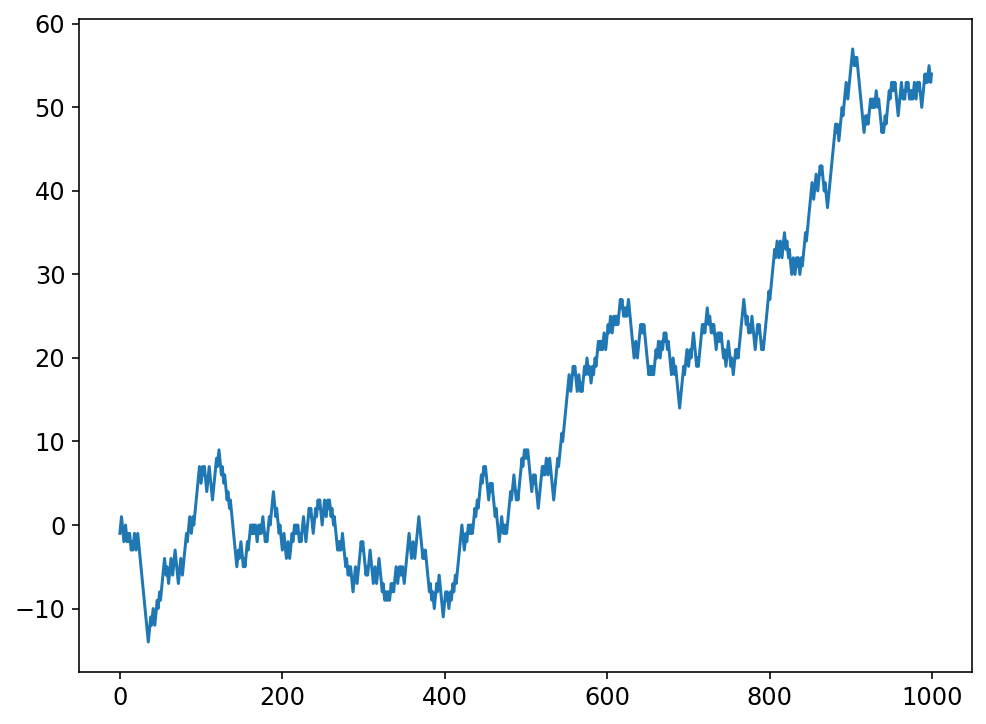

In [3]:
from random import random, seed 

seed(1)
random_walk = [-1 if random() < 0.5 else 1]
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)

plt.plot(random_walk)
plt.show()

Upon plotting the random walk we just generated, we can see that this looks like a valid time series data. In the next few sections, we will take a closer look at various properties of a random walk, and why we might want to analyze whether the time series data that we're dealing with is a random walk or not.

## Stationarity

The discussion of stationary can be a topic by itself as it is often times an important assumption made by a lot of tools in time series analysis. We will touch upon it briefly by highlighting why it is important, and what tools do we have to identify them.

A stationary time series is one in which its properties such as mean, variance and covariance are not a function of time, i.e. do not vary with time. Note that this doesn't mean the time series itself doesn't change over, it means the *way* it changes does not change over time. For example, time series with patterns such as trend or seasonality, are not stationary, as the trend and seasonality will introduce time-dependent patterns to the time series.

Recall that the random walk that we're dealing with was constructed by taking a random step from the previous record, hence we can expect a random walk to be non-stationary as the series is time-dependent. Note that the vice versa does not hold true, i.e. not all non-stationary time series is a random walk.

One quick way of making a time series stationary is to take the first order difference, by taking the difference between the current observation and the previous observation, we're essentially removing the changes caused by any time-related patterns and stabilizing the time series' mean. 

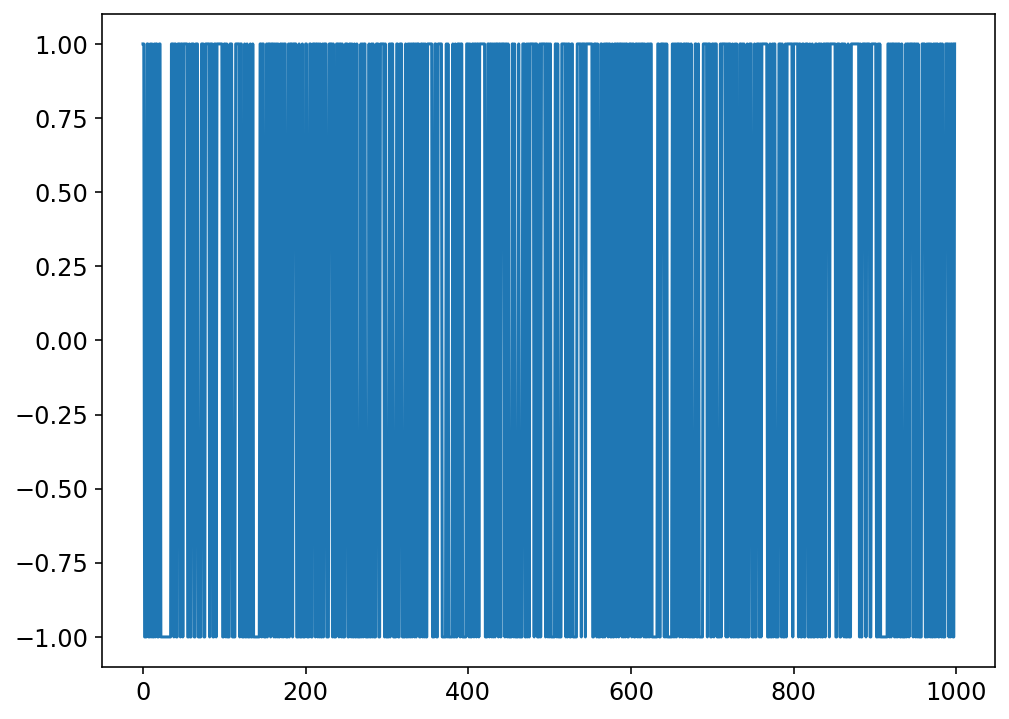

In [4]:
random_walk_diff = np.diff(random_walk)
plt.plot(random_walk_diff)
plt.show()

Upon taking the first order difference of our random walk, and plotting it, we unveil the arbitrary fluctuations nature, showing that we have no information to work with here.

Visualizing the data gives us some intuition about the data that we're working with, however, checking whether a time series is stationary through eye-balling can feel a bit sketchy, which leads us to our next topic.

### Autocorrelation

Autocorrelation is a measurement that captures the similarity between a given time series and its lagged version over different time intervals. The idea is the same as calculating the correlation between two series of numbers, except autocorrelation uses the same series twice, one in its original form and the other in a lagged form.

When using [`pandas' autocorrelation_plot`](https://github.com/pandas-dev/pandas/blob/8ea102acdb45bb70cb30ea77108a50054c28c24d/pandas/plotting/_matplotlib/misc.py#L403) function to plot autocorrelation value for increasing time lags, a.k.a correlogram, it shows that our random walk has a strong autocorrelation at lag 1, and then the relationship gradually degrades as the lag step increases. This gradual decrease is a pattern that often exists for non-stationary time series, as for stationary time series the drop would appear much quicker.

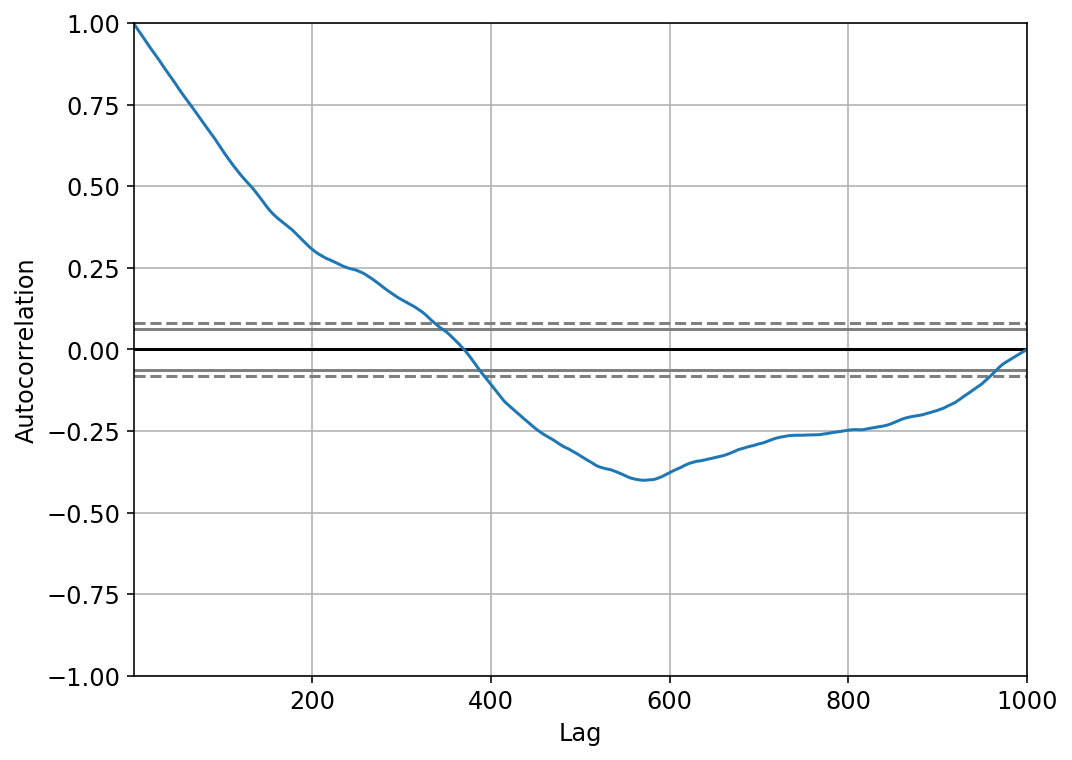

In [5]:
from pandas.plotting import autocorrelation_plot


autocorrelation_plot(random_walk)
plt.show()

We can leverage the autocorrelation plot on the first order differenced series and see that there isn't really any relationship between the lagged observations.

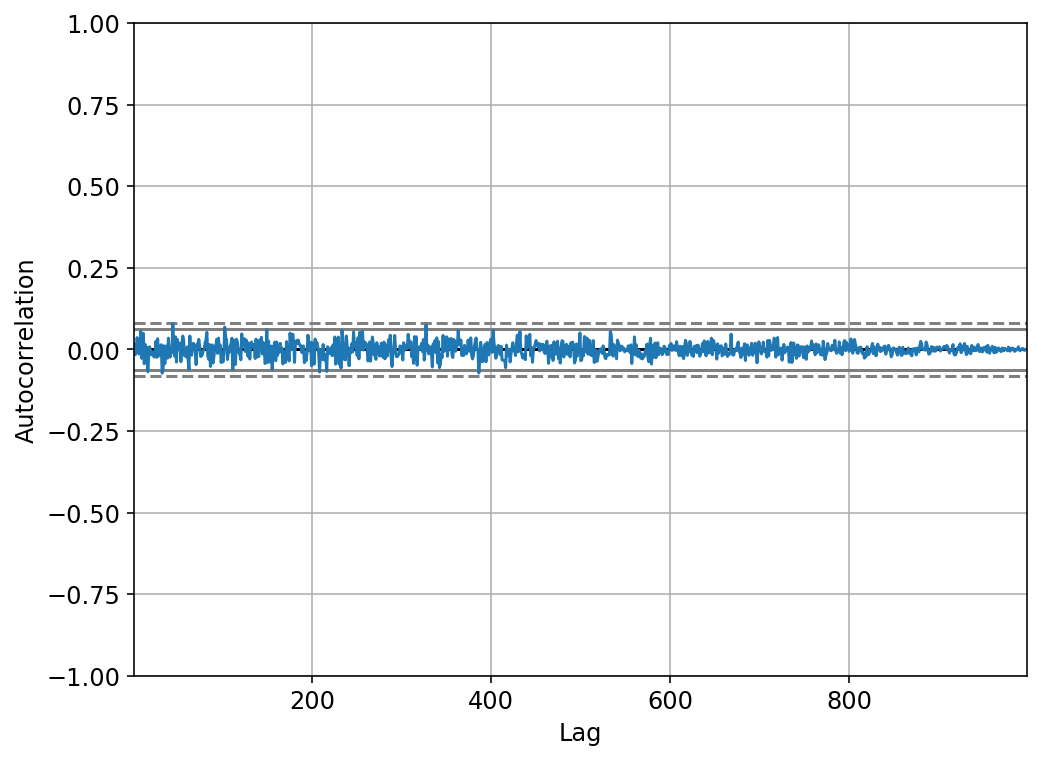

In [6]:
autocorrelation_plot(random_walk_diff)
plt.show()

### Statistical Tests

The other approach to check for stationary is to leverage statistical tests, such as **ADF (Augmented Dickey Fuller) Test** and **KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test**.

- http://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html
- https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss

adfuller_result = adfuller(random_walk)
adfuller_result[1]

0.9791747967918744

The null hypothesis of the test is that the time series is non-stationary. Looking at the p-value, we can say that we can't reject the null hypothesis, hence the time series data at hand appear to be non-stationary with a low likelihood of it being a statistical fluke.

In [14]:
kpss_result = kpss(random_walk)
kpss_result[1]

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


0.01

Both test are used for testing different types of stationary

## Prediction

When building machine learning application, it is always important to keep track of our baselines to make sure whatever improvements we think we're making actually has an effect.

As random walks are constructed by adding some random number to the value of the previous time step, we can expect the best prediction we can make is to the use the value at the previous time step to make prediction of what will be the value of the next time step. This type of naive prediction should serve as the baseline of any time series forecasting problem, and the evaluation metrics of this naive prediction can tell us whether it is worth our effort to develop more sophisticated algorithms.

In [7]:
# prepare dataset
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[:train_size], random_walk[train_size:]

# naive prediction
predictions = []
yhat = train[-1]
for i in range(len(test)):
    predictions.append(yhat)
    yhat = test[i]

mse_test = mean_squared_error(test, predictions)
r2_test = r2_score(test, predictions)
print('Persistence MSE: %.3f' % mse_test)
print('Persistence R-squared: %.3f' % r2_test)

Persistence MSE: 1.000
Persistence R-squared: 0.994


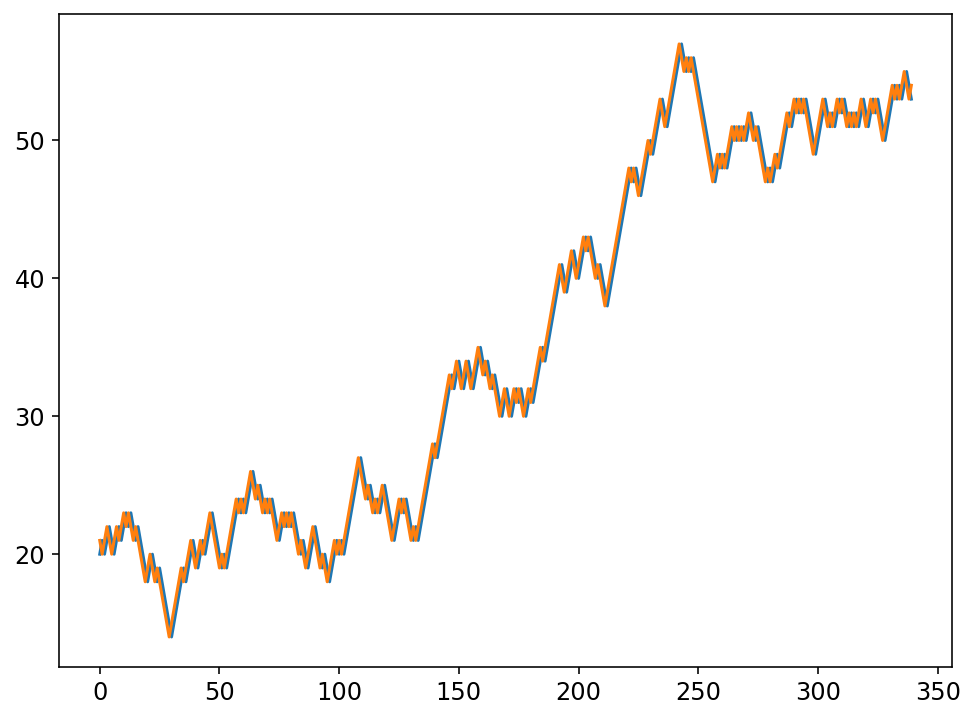

In [8]:
plt.plot(predictions)
plt.plot(test)
plt.show()

By using a naive previous step prediction, we were able to reach a r-squared value almost close to 1 on the test set.

# TakeAways

As humans, we tend to see patterns or try to look for patterns everywhere to come up with justification of the phenomenon that we're observing. However, next time when we're given a time series prediction problem, we should always remember to check the performance of a naive prediction method and see whether its performance still leaves a lot to be desired before jumping straight into more sophisticated models. Because if the time series at hand resembles a random walk, then our model that may seem to performance well might actually have no prediction power whatsoever.

# Reference

- [Blog: A Gentle Introduction to the Random Walk for Times Series Forecasting with Python](https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/)
- [Blog: How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)
- [Blog: A Gentle Introduction to Handling a Non-Stationary Time Series in Python](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)
- [Online Book: Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition - 8.1 Stationarity and differencing](https://otexts.com/fpp2/stationarity.html)